In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [115]:
class Network(nn.Module):

  def __init__(self, input, width, depth, output):
    super().__init__()

    # activation function
    activation = nn.Tanh

    # input layer
    self.fci = nn.Sequential(*[nn.Linear(input, depth), activation()])

    # hidden layers
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(depth, depth), activation()]) for i in range(width-1)])

    # output layer
    self.fco = nn.Linear(depth, output)

  # forward propagation
  def forward(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    return x
  
  # exact solution of modelling coursework
  def NumericalSoln(self, r_rms, t_rms):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_rms)):
      r = np.round(10000 * r_rms[i]).astype(int)[0]
      t = np.round(400 * t_rms[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      sol.append(c)
    return sol
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary
  
  def physics_sample(self, N):
      
      # sample points for training
      r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
      t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
  
      return r, t
  
  def rms_sample(self, N):
        
        # sample points for training
        r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
        t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
    
        return r, t
  
  def Diffusion_Coeff(self, c, D_ref):
    # constants
    #D_ref = 2e-16
    c_max = 4.665e4
    C_theory = 277.84
    C_practical = 160

    # equations
    SOC = (c_max - c*c_max)/c_max * C_theory/C_practical
    D = D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def c_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(r).to(device), create_graph=True)[0]
  
  def c_rr(self, c, r):
    c_r = self.c_r(c, r)
    return torch.autograd.grad(c_r, r, grad_outputs=torch.ones_like(c_r).to(device), create_graph=True)[0]
  
  def c_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def constants(self):
    j = -5.35e-5
    Rs = 2e-6
    c_max = 4.665e4
    c0 = torch.tensor(2e4).view(-1, 1).to(device)

    return j, Rs, c_max, c0
  
  def losses(self, r_rms, t_rms, c_numerical, D, N):

    r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary = self.init_boundaries(N)
    r_phys, t_phys = self.physics_sample(N)
    j, Rs, c_max, c0 = self.constants()

    # losses for x and t boundaries
    r0_loss = torch.empty(0).to(device)
    for t in t_boundaries:
      t = t.unsqueeze(1)
      c = self.forward(r0_boundary, t)
      c_r = self.c_r(c, r0_boundary)
      r0_loss = torch.cat((r0_loss, c_r**2), 0)
    
    rs_loss = torch.empty(0).to(device)
    for t in t_boundaries:
      t = t.unsqueeze(1)
      c = self.forward(rs_boundary, t)
      c_r = self.c_r(c, rs_boundary)
      #D = self.Diffusion_Coeff(c.item(), D_ref)
      
      rs_loss = torch.cat((rs_loss, (D*c_r + j*Rs/c_max)**2), 0)
    
    t0_loss = torch.empty(0).to(device)
    for r in r_boundary:
      r = r.unsqueeze(1)
      c = self.forward(r, t0_boundary)
      t0_loss = torch.cat((t0_loss, (c_max*c**2 - c0)**2), 0)

    # loss for physics sample
    phys_loss = torch.empty(0).to(device)
    for i in range(len(r_phys)):

      r = r_phys[i].view(-1, 1)
      t = t_phys[i].view(-1, 1)

      c = self.forward(r, t)
      c_r = self.c_r(c, r)
      c_rr = self.c_rr(c, r)
      c_t = self.c_t(c, t)

      #D = self.Diffusion_Coeff(c, D_ref)

      phys_loss = torch.cat((phys_loss, (r**2*c_t - 2*r*D/Rs**2*c_r - r**2*D/Rs**2*c_rr)**2), 0)
    
    rms_loss = torch.empty(0).to(device)
    for i in range(len(r_rms)):
      c = self.forward(r_rms[i].view(-1, 1), t_rms[i].view(-1, 1))
      rms_loss = torch.cat((rms_loss, (c_max*c - c_numerical[i])**2), 0)
    
    #print(torch.mean(r0_loss).item(), torch.mean(rs_loss).item(), torch.mean(t0_loss).item(), torch.mean(phys_loss).item(), torch.mean(rms_loss).item(), end='\r')
    loss = 1e-4 * (torch.mean(r0_loss) + torch.mean(rs_loss) + torch.mean(t0_loss) + torch.mean(phys_loss)) + torch.mean(rms_loss)  

    return loss
  
  def train(self, epochs, lr, N):

    # get analytical solution for training
    r_rms, t_rms = self.rms_sample(N)
    c_numerical = torch.tensor(self.NumericalSoln(r_rms.cpu().detach().numpy(), t_rms.cpu().detach().numpy())).to(device)

    # initialise parameters and optimiser
    #D_ref = torch.nn.Parameter(torch.tensor(1.).to(device), requires_grad=True)
    D = torch.nn.Parameter(torch.tensor(0.).to(device), requires_grad=True)
    #D_ref = torch.tensor(2e-16)
    Ds = [] 
    losses = []
    optimizer = torch.optim.Adam(list(self.parameters()) + [D], lr = lr)
    #optimizer = torch.optim.Adam(self.parameters(), lr = lr)
    

    for epoch in range(epochs):
      
      optimizer.zero_grad()
      # find loss
      loss = self.losses(r_rms, t_rms, c_numerical, D.item(), N)
      _, _, c_max, _ = self.constants()
      # store parameter and loss values
      Ds.append(D.item())
      losses.append(loss.item())
      # backpropagation
      loss.backward()
      optimizer.step()
      # print loss and parameter values
      print(f'Epoch: {epoch}  Loss: {loss.item()}, D: {D.item()}', end='\r')

      if epoch % 3333 == 0:
        self.plot(c_max)

    return Ds, losses

  def plot(self, c_max):
      
      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      
      C = np.zeros((len(X), len(T)))
      for i in range(len(X)):
        x = X[i].view(-1, 1)
        for j in range(len(T)):
          t = T[j].view(-1, 1)
          c = self.forward(x, t)
          C[i, j] = c_max * c.item()
      
      X, T = np.meshgrid(X.cpu().detach().numpy(), T.cpu().detach().numpy())
      fig = plt.figure()
      fig.clear()
      ax = fig.add_subplot(111, projection='3d')
      ax.plot_surface(X, T, C, cmap='viridis')
      
      plt.show()
  


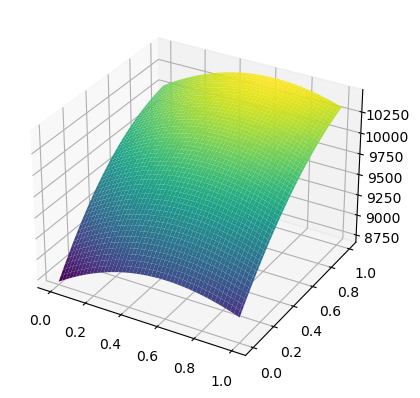

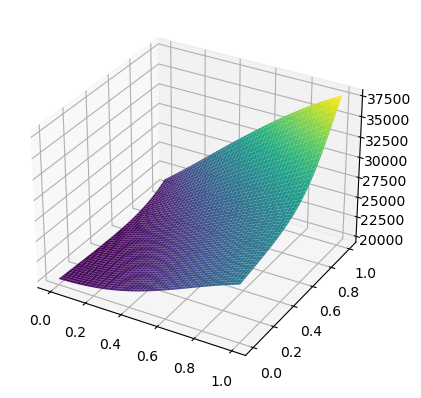

In [116]:
# nn seed
torch.manual_seed(938)
device = 'cpu'

# define nn to train, two inputs for x and t
pinn = Network(2, 5, 128, 1).to(device)

# training things
epochs = 20000
lr = 1e-3
N = 100


Ds, losses = pinn.train(epochs, lr, N)

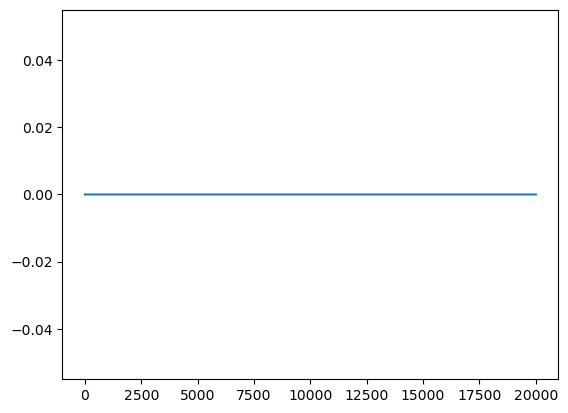

In [113]:
plt.plot(Ds)

[[21690 20020 21564 ... 21564 20814 20849]
 [28092 23179 27861 ... 27861 26350 26428]
 [23050 20308 22897 ... 22897 21923 21971]
 ...
 [23430 20443 23270 ... 23270 22246 22298]
 [28209 23259 27975 ... 27975 26452 26531]
 [23138 20337 22984 ... 22984 21997 22047]]


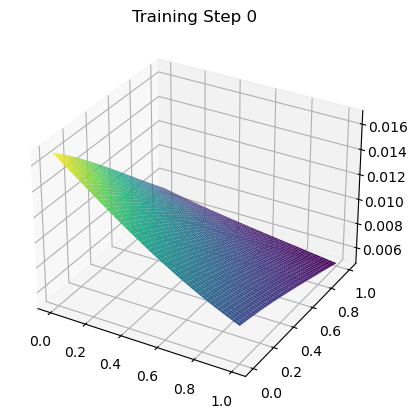

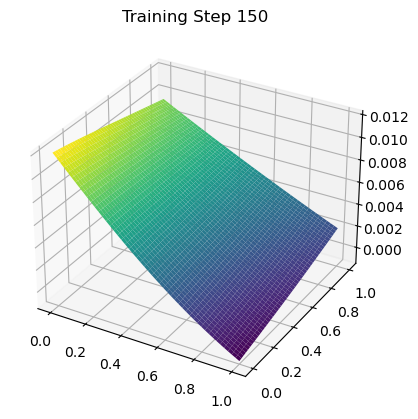

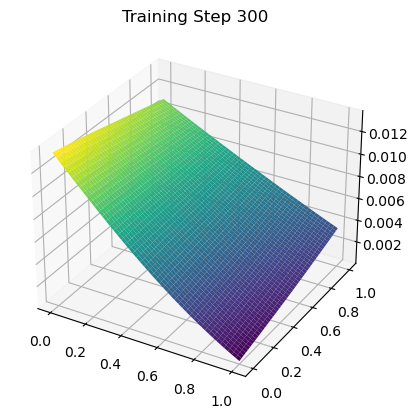

KeyboardInterrupt: 

In [153]:
# define nn to train, two inputs for x and t
pinn = Network(2, 5, 128, 1).to(device)

# parameters and things
Rs = 5e-6
j = -5.35e-5
C0 = 2e4
Cm = 4.665e4

t_points = torch.round(400 * torch.rand(100).view(-1, 1).to(device))
r_points = torch.round(10000 * torch.rand(100).view(-1, 1).to(device))
data = numerical.iloc[r_points.numpy().flatten().astype(int), t_points.numpy().flatten().astype(int)].reset_index(drop=True).values
print(data)


# x and t boundary points for training x boundaries, x = 0,1, varying t values
r0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
rs_boundary = torch.tensor(Rs).view(-1, 1).requires_grad_(True).to(device)
t_boundaries = torch.linspace(0, 400, 100).view(-1, 1).requires_grad_(True).to(device)

# 0 time boundary for training
t0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
r_boundary = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True).to(device)


# training things
epochs = 30000
lr = 1e-5
lambda_r0= 1
lambda_Rs = 1
lambda_t = 1
lambda1 = 1e-4
lambda_phys = 1e-4

def closure():
    # Calculate loss and gradients here
    loss.backward()
    
    return loss

Rs = 5e-6

D_ref = torch.nn.Parameter(torch.zeros(1, requires_grad = True).to(device))

# optimiser
optimiser = torch.optim.Adam(list(pinn.parameters()) + [D_ref], lr = lr)
#optimiser = torch.optim.LBFGS(list(pinn.parameters()) + [D_ref], lr = lr)

losses = []

for e in range(epochs):

  

  optimiser.zero_grad()

  # x, t for phsyics loss
  r_physics = torch.round(10000 * torch.rand(100).requires_grad_(True).to(device))
  t_physics = torch.round(400 * torch.rand(100).requires_grad_(True).to(device))

  # r0 boundary loss
  #outputs = torch.empty(0).to(device)
  #for t in t_boundaries:
  #  t = t.unsqueeze(1)
  #  c = pinn(r0_boundary, t)
  #  c_r = torch.autograd.grad(c, r0_boundary, torch.ones_like(r0_boundary), create_graph = True)[0]
  #  outputs = torch.cat([outputs, c_r], dim = 0)

  #r0_loss = torch.mean(outputs**2)
  #print(f"r0_loss: {r0_loss}")
  
  

  # Rs boundary loss
  #outputs = torch.empty(0).to(device)
  #for t in t_boundaries:
  #  t = t.unsqueeze(1)
  #  c = pinn(rs_boundary, t)
  #  print(c)
  #  c_r = torch.autograd.grad(c, rs_boundary, torch.ones_like(rs_boundary), create_graph = True)[0]
  #  D = Diffusion_Coeff(c)
  #  outputs = torch.cat([outputs, (D*c_r + j)], dim = 0)

  #Rs_loss = torch.mean((outputs)**2)
  #print(f"D: {D.item()}")
  #print(f"Rs_loss: {Rs_loss}")
  

  # t boundary loss
  #outputs = torch.empty(0).to(device)
  #for r in r_boundary:
  #  r = r.unsqueeze(1)
  #  c = pinn(r, t0_boundary)
  #  outputs = torch.cat([outputs, c_r-C0], dim = 0)

  #t_loss = torch.mean(outputs**2)
  #print(f"t_loss: {t_loss}")

  loss1_list = torch.tensor([]).to(device)

  for i in range(len(r_points)):
    r = 1/10000 * r_points[i].view(-1, 1)

    for j in range(len(t_points)):
      t = 1/400 * t_points[j].view(-1, 1)

      loss = torch.mean((pinn(r, t) - data[i, j])**2)
      
      loss1_list = torch.cat([loss1_list, loss.unsqueeze(0)], dim = 0)

  loss1 = torch.mean(loss1_list)

  loss_phys_list = torch.empty(0).to(device)
  # physics loss function
  for i in range(len(r_physics)):
    r = 1/10000 * r_physics[i].view(-1, 1)
    t = 1/400 * t_physics[i].view(-1, 1)

    c = pinn(r, t)
    c_r = torch.autograd.grad(c, r, torch.ones_like(r), create_graph = True)[0]
    c_rr = torch.autograd.grad(c_r, r, torch.ones_like(r), create_graph = True)[0]
    c_t = torch.autograd.grad(c, t, torch.ones_like(t), create_graph = True)[0]

    # find and store loss function
    D = Diffusion_Coeff(c, D_ref)
    loss = r**2 * c_t - D*(r/Rs)**2*c_rr - 2*D*r/Rs*c_r
    loss_phys_list = torch.cat([loss_phys_list, loss], dim = 0)


  loss_phys = torch.mean(loss_phys_list**2)
  #print(f"loss_phys: {loss_phys}")

  loss = lambda1 * loss1 +  lambda_phys * loss_phys
  losses.append(loss.cpu().item())
  loss.backward()
  optimiser.step()

  print(f'Iteration: {e}, Loss: {losses[-1]}', end='\r')

  if e % 150 == 0:

    X = torch.linspace(0, 1, 50).to(device)
    T = torch.linspace(0, 1, 50).to(device)
    cs = np.zeros((50, 50))

    for i in range(len(X)):
        x = X[i].view(-1, 1)
        for j in range(len(T)):
            t = T[j].view(-1, 1)

            c = pinn(x, t)
            cs[i, j] = c.item()


    X, T = np.meshgrid(X.cpu().numpy(), T.cpu().numpy())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, cs, cmap='viridis')

    plt.title(f"Training Step {e}")
    plt.show()

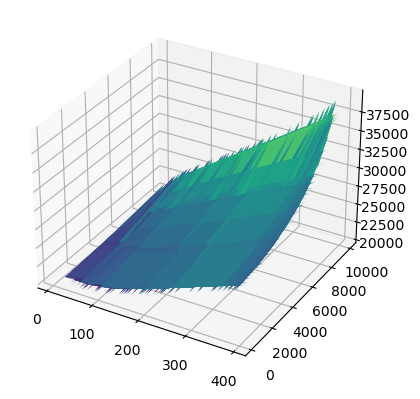

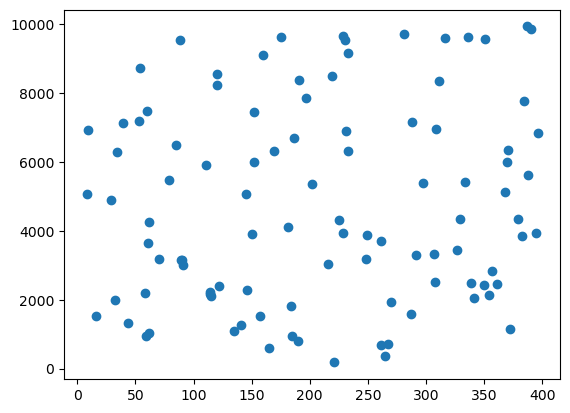

In [123]:
numerical.iloc[r_points.numpy().flatten().astype(int), t_points.numpy().flatten().astype(int)]


r, t = np.meshgrid(t_points.numpy(), r_points.numpy())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(r, t, numerical.iloc[r_points.numpy().flatten().astype(int), t_points.numpy().flatten().astype(int)], cmap='viridis')
plt.show()

plt.scatter(t_points, r_points)



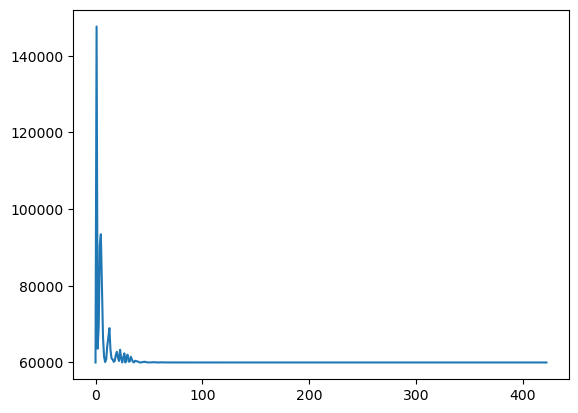

In [154]:
plt.plot(losses)